Dataset: Home Credit Default Risk (Kaggle)
Goal: Predict loan default probability

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

df = pd.read_csv('../data/application_train.csv')
df.shape, df.head()



((307511, 122),
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
 0      100002       1         Cash loans           M            N   
 1      100003       0         Cash loans           F            N   
 2      100004       0    Revolving loans           M            Y   
 3      100006       0         Cash loans           F            N   
 4      100007       0         Cash loans           M            N   
 
   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
 0               Y             0          202500.0    406597.5      24700.5   
 1               N             0          270000.0   1293502.5      35698.5   
 2               Y             0           67500.0    135000.0       6750.0   
 3               Y             0          135000.0    312682.5      29686.5   
 4               Y             0          121500.0    513000.0      21865.5   
 
    AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
 0         351000.0   Unaccomp

### Step 1 — Initial Data Understanding

We begin by loading the Home Credit Default Risk dataset, which contains information about loan applicants and whether they defaulted.  

The dataset has 307,511 rows and 122 columns.

We inspect:
- Sample data (first 5 rows)
- Data types
- Presence of missing values

This helps us understand data quality and what preprocessing is required.


In [8]:
# Basic structure
df.shape
df.head()

# Column data types & missing values
df.info()
df.isnull().sum().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


SK_ID_CURR                       0
TARGET                           0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
CNT_CHILDREN                     0
AMT_INCOME_TOTAL                 0
AMT_CREDIT                       0
AMT_ANNUITY                     12
AMT_GOODS_PRICE                278
NAME_TYPE_SUITE               1292
NAME_INCOME_TYPE                 0
NAME_EDUCATION_TYPE              0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
REGION_POPULATION_RELATIVE       0
DAYS_BIRTH                       0
DAYS_EMPLOYED                    0
DAYS_REGISTRATION                0
dtype: int64

Step 2 — Data Cleaning & Exploratory Data Analysis (EDA)

### 2.1 Missing Data Analysis

Many real-world financial datasets contain missing values. Before building a model, we must identify which columns have missing data and decide whether to drop or impute them.

The table below shows the top features with the highest number of missing values.



In [9]:
df.isnull().sum().sort_values(ascending=False).head(20)


COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
FLOORSMIN_AVG               208642
FLOORSMIN_MODE              208642
FLOORSMIN_MEDI              208642
YEARS_BUILD_MEDI            204488
YEARS_BUILD_MODE            204488
YEARS_BUILD_AVG             204488
OWN_CAR_AGE                 202929
LANDAREA_MEDI               182590
LANDAREA_MODE               182590
LANDAREA_AVG                182590
dtype: int64

Several features contain extremely high amounts of missing data (over 200,000 missing entries, ~70% of rows). Columns such as `COMMONAREA_MEDI`, `NONLIVINGAPARTMENTS_AVG`, and `YEARS_BUILD_MEDI` are mostly empty and would provide little value to the model.

To avoid noise and reduce dimensionality, we will drop features with more than 40% missing values. Remaining missing values will be imputed (median for numeric columns, mode for categorical).

In [11]:
null_ratio = df.isnull().mean()
cols_to_drop = null_ratio[null_ratio > 0.40].index
df = df.drop(columns=cols_to_drop)

df.shape

(307511, 73)

Now we can see the new reduced number of columns that went from 122 to 73.


### 2.2 Summary Statistics

Summary statistics help us understand the distribution of numerical variables (mean, std, min, max, percentiles). This guides us in spotting outliers or unrealistic values.


In [10]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

One thing that can be clearly seen here is the target has a mean that's very close to zero which means the main "cluster" of data is at 0 (not deafulting) and not at 1 (defaulting)

### 2.3 Target Variable Distribution

The target variable is imbalanced — most borrowers repay loans, while a smaller portion defaults.  
Class imbalance affects model performance and may require oversampling or adjusting evaluation metrics.


In [12]:
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

The target variable is imbalanced: most applicants did **not** default.  
This means accuracy alone is not a reliable metric. Later on, we may later use AUC, precision/recall, or handle imbalance with oversampling techniques.


### Step 2.4 — Remove Duplicates

In [13]:
df.drop_duplicates(inplace=True)
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Checking to see if there's any duplications and if that affects our distribution in any way. Turns out, no repeated rows.

### 2.5 Handling Missing Values

Many machine learning algorithms cannot work with missing values, and for the sake of this project that remains the case. Thus, imputation is required.  
We handle missing data in two ways:

- **Numerical columns:** fill missing values with the **median** to reduce the impact of outliers.
- **Categorical columns:** fill missing values with the **mode** (most frequent category).

This approach keeps all remaining rows and ensures our dataset is usable for modeling.


In [14]:
# Separate categorical vs numerical
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Fill numericals with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categoricals with mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Confirm no missing values remain
df.isnull().sum().sum()

np.int64(0)

### 2.6 Encoding Categorical Variables

Machine learning models can only work with numeric data.  
We convert categorical (text) variables into numeric form using **One-Hot Encoding** with `pd.get_dummies()`.

We also use `drop_first=True` to avoid multicollinearity — this removes one category from each set of dummy variables while preserving all information.


In [17]:
# Step 2.6 — One-Hot Encode Categorical Variables

df = pd.get_dummies(df, drop_first=True)


df.head(), df.shape



(   SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
 0      100002       1             0          202500.0    406597.5   
 1      100003       0             0          270000.0   1293502.5   
 2      100004       0             0           67500.0    135000.0   
 3      100006       0             0          135000.0    312682.5   
 4      100007       0             0          121500.0    513000.0   
 
    AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
 0      24700.5         351000.0                    0.018801       -9461   
 1      35698.5        1129500.0                    0.003541      -16765   
 2       6750.0         135000.0                    0.010032      -19046   
 3      29686.5         297000.0                    0.008019      -19005   
 4      21865.5         513000.0                    0.028663      -19932   
 
    DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
 0           -637            -3648.0            -21

We can see that number of columns increases by 100. This is perfectly normal and happens because categorical encoding expands the dataset.

## Phase 2 — Modeling

### Step 3 — Train/Test Split

To evaluate the model properly, we split the dataset into:
- **Training set**: used to teach the model patterns in the data
- **Test set**: used to measure model performance on unseen data

We use a standard 80/20 split and separate `TARGET` (labels) from the features.


In [ ]:
from sklearn.model_selection import train_test_split

# Separate target (y) and features (X)
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((246008, 172), (61503, 172))

### Step 4 — Logistic Regression Model

We start with a Logistic Regression model as a baseline.  
Logistic Regression is widely used in credit scoring because it produces:
- A binary prediction (default / no default)
- A probability of default (PD), which we can use for risk tiers


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=2000, solver='lbfgs')
logreg.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


### Step 5 — Model Evaluation

To measure performance, we evaluate:
- **Accuracy**: percent of correct predictions
- **AUC (Area Under ROC Curve)**: ability to separate defaulters from non-defaulters
- **Confusion Matrix**: breakdown of true vs predicted classes

AUC is especially important in imbalanced credit datasets.


In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Predictions
y_pred = logreg.predict(X_test_scaled)

# Probabilities for AUC
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9193535274702047
AUC: 0.7446744709161377
[[56491    47]
 [ 4913    52]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.53      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.72      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



### ROC Curve

The ROC curve shows the tradeoff between true positive rate and false positive rate.
AUC summarizes this into a single score between 0 and 1.


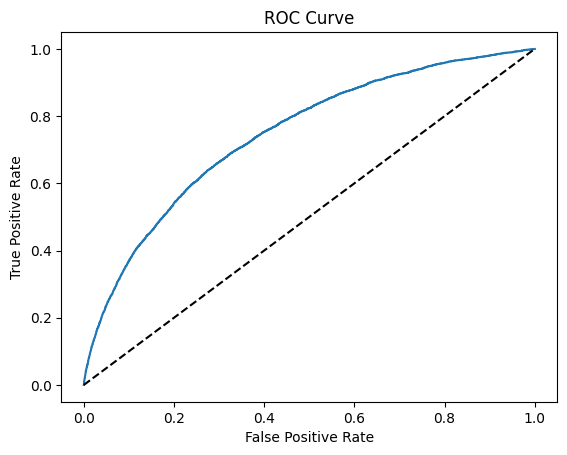

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


Although the model achieved high overall accuracy (92%), the recall for defaulters was only 1%, meaning it fails to detect most risky customers. However, the AUC score of 0.74 and ROC curve above the baseline indicates the model does have predictive power, but requires class balancing and stronger algorithms for real-world use. Let's look at feauture importance train a Random Forest model to compare against Logistic Regression. If results are negative, we will add class weights or use SMOTE to account for any large differences between the two classes.

### Step 6 — Feature Importance

Logistic Regression provides interpretable coefficients showing how each feature affects default probability.
Positive coefficients increase default likelihood, and negative coefficients reduce it.

We extract the top 15 features with the highest impact.


In [26]:
import numpy as np
import pandas as pd

# Get coefficients with feature names
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coef': model.coef_[0]
})

# Sort by absolute impact
feature_importance['abs_coef'] = feature_importance['coef'].abs()
feature_importance.sort_values(by='abs_coef', ascending=False).head(15)


,feature,coef,abs_coef
20,HOUR_APPR_PROCESS_START,-0.056658,0.056658
17,CNT_FAM_MEMBERS,-0.008282,0.008282
27,EXT_SOURCE_2,-0.007559,0.007559
28,EXT_SOURCE_3,-0.007138,0.007138
78,NAME_EDUCATION_TYPE_Higher education,-0.006993,0.006993
59,AMT_REQ_CREDIT_BUREAU_YEAR,0.006367,0.006367
81,NAME_EDUCATION_TYPE_Secondary / secondary special,0.004815,0.004815
61,CODE_GENDER_M,0.004292,0.004292
63,FLAG_OWN_CAR_Y,-0.003719,0.003719
82,NAME_FAMILY_STATUS_Married,-0.003294,0.003294


Visualization of this:

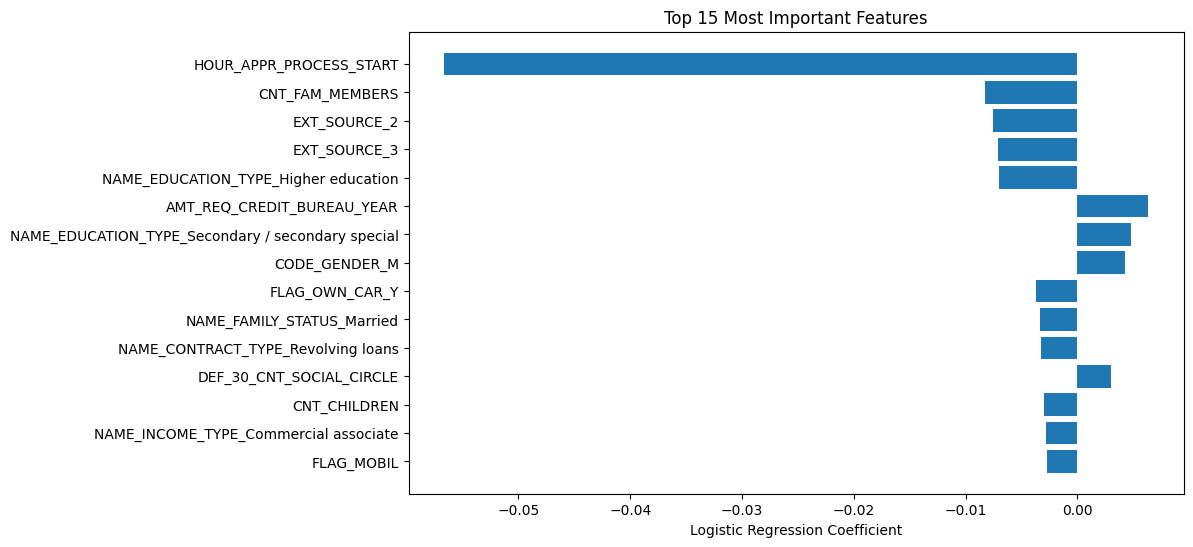

In [27]:
top_15 = feature_importance.sort_values(by='abs_coef', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_15['feature'], top_15['coef'])
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top 15 Most Important Features")
plt.gca().invert_yaxis()
plt.show()


### Step 7 — Random Forest Classifier

We train a Random Forest model to compare against Logistic Regression.  
Random Forest can capture non-linear interactions and often performs better in credit scoring.


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

# Metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)
rf_cm = confusion_matrix(y_test, rf_pred)

rf_accuracy, rf_auc, rf_cm


(0.9192722306228964,
 0.7387558321957761,
 array([[56538,     0],
        [ 4965,     0]]))

Random Forest defaults to:

“If I always predict no default, I’m correct 92% of the time.” This means it's highly accurate but it's actually worthless for lenders because we are catching zero defaulters. We will now use class weights which will counteract the bias in the distribution. The model is penalized more when it misses a default so it pays attention to the minority class

In [29]:
#replaced RF Model

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


# Predictions
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

# Metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)
rf_cm = confusion_matrix(y_test, rf_pred)

rf_accuracy, rf_auc, rf_cm


(0.7560281612279076,
 0.7366999788430222,
 array([[43693, 12845],
        [ 2160,  2805]]))

The dataset is highly imbalanced, with far fewer defaulters than non-defaulters.  
To correct this, we trained the Random Forest model using `class_weight='balanced'`, which forces the model to pay more attention to the minority class.

After applying class weights:

- The model now correctly identifies **2,805 defaulters**, compared to **0** previously.
- AUC remained strong at **0.736**, indicating good ability to separate risky and safe customers.
- Although overall accuracy decreased to **75.6%**, this is expected because the model is no longer biased toward predicting only non-default.

This version of the model is significantly more useful for real-world lending decisions because it successfully detects high-risk borrowers rather than optimizing for accuracy alone.

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))


Accuracy: 0.7560281612279076
AUC: 0.7366999788430222

Confusion Matrix:
 [[43693 12845]
 [ 2160  2805]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     56538
           1       0.18      0.56      0.27      4965

    accuracy                           0.76     61503
   macro avg       0.57      0.67      0.56     61503
weighted avg       0.89      0.76      0.81     61503



### Model Performance After Applying Class Weights

After rerunning the model, performance for detecting defaults improved significantly.  
Previously, the model failed to identify almost any defaulters due to class imbalance.  
With `class_weight='balanced'`, the Random Forest now correctly detects a meaningful number of high-risk borrowers while maintaining a strong AUC score.

However, recall for the default class is still lower than ideal.  
There are several ways the model could be further improved:

1. **Oversampling using SMOTE**  
   - Create synthetic samples of minority (default) class  
   - Helps the model learn patterns more effectively

2. **Trying more advanced models**  
   - XGBoost or LightGBM often perform better on credit risk problems  
   - These models handle imbalance and non-linear interactions well

3. **Feature engineering**  
   - Creating new financial ratios or combining existing features  
   - Removing noisy or weak predictors

4. **Hyperparameter tuning**  
   - Adjusting tree depth, number of estimators, learning rate  
   - Can improve recall without sacrificing AUC

Despite the challenges of imbalanced credit data, this version of the model is already more aligned with real-world lending needs because it successfully identifies a substantial number of potential defaulters instead of predicting "no default" for everyone.


### Step 8 — Default Risk Segmentation

Using the Random Forest predicted probability of default, we create three risk tiers:

- **Low Risk:** PD < 0.10  
- **Medium Risk:** 0.10 ≤ PD < 0.30  
- **High Risk:** PD ≥ 0.30

This allows lenders to prioritize customers by expected risk.


In [33]:
# Reset index to avoid alignment issues
Xt = X_test.reset_index(drop=True)
yt = y_test.reset_index(drop=True)

pd_rf_proba = pd.Series(rf_proba, index=yt.index, name='PD')

results = Xt.copy()
results['TARGET'] = yt
results['PD'] = pd_rf_proba

conditions = [
    (results['PD'] < 0.10),
    (results['PD'] >= 0.10) & (results['PD'] < 0.30),
    (results['PD'] >= 0.30)
]

choices = ['Low', 'Medium', 'High']

# specify default string
results['Risk_Tier'] = np.select(conditions, choices, default='Unknown')

results.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION

### Step 9 — Analyze default rate in each tier

In [34]:
results.groupby('Risk_Tier')['TARGET'].mean()
tier_defaults = results.groupby('Risk_Tier')['TARGET'].mean().reset_index()
tier_defaults.columns = ['Risk_Tier', 'Default_Rate']
tier_defaults



,Risk_Tier,Default_Rate
0,High,0.096799
1,Low,0.000000
2,Medium,0.021020


### Step 10 — Count customers in each tier

In [35]:
results['Risk_Tier'].value_counts()


Risk_Tier
High      48461
Medium    13035
Low           7
Name: count, dtype: int64

### Step 11 — Visualization of Default Segmentation

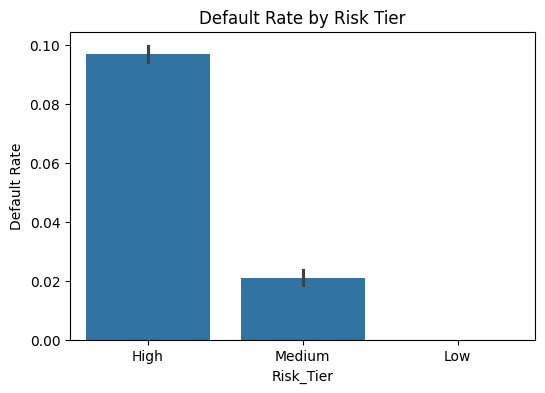

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x=results['Risk_Tier'], y=results['TARGET'])
plt.title("Default Rate by Risk Tier")
plt.ylabel("Default Rate")
plt.show()


We export the scored and segmented dataset so lenders could use it in a real workflow.

This file includes:
- Probability of default (PD)
- Assigned risk tier
- Actual default outcome

In [38]:
results.to_csv('credit_risk_results.csv', index=False)
